In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")
from matplotlib.image import imread
from sklearn.metrics import classification_report
#tensorflow modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
img_dir = "C:/Users/tanis/OneDrive/Desktop/mini/dataset"
img_dir

'C:/Users/tanis/OneDrive/Desktop/mini/dataset'

In [6]:
train_path = "C:\\Users\\tanis\\OneDrive\\Desktop\\mini\\dataset\\ALL_IDB1\\ALL_IDB1\\im"
len(os.listdir(train_path))

108

In [7]:
sample_image = os.listdir(train_path)[0]
sample_image

'Im001_1.jpg'

In [8]:
sample_image_id = os.listdir(train_path)[0][6]
sample_image_id

'1'

In [9]:
train_files = os.listdir(train_path)

In [10]:
os.makedirs("out\\clean_data")
os.makedirs("out\\clean_data\\1")
os.makedirs("out\\clean_data\\0")

In [12]:
clean_train_path = "C:\\Users\\tanis\\OneDrive\\Desktop\\mini\\out\\clean_data"
clean_1_path = "C:\\Users\\tanis\\OneDrive\\Desktop\\mini\\out\\clean_data\\1"
clean_0_path = "C:\\Users\\tanis\\OneDrive\\Desktop\\mini\\out\\clean_data\\0"

In [15]:
import shutil
for fname in train_files:
    if(fname[6]=="1"):
        shutil.copy2(os.path.join(train_path, fname), clean_1_path)
    else:
        shutil.copy2(os.path.join(train_path, fname), clean_0_path)

In [16]:
print(f"No. of files in class '0' is {len(os.listdir(clean_0_path))}")
print(f"No. of files in class '1' is {len(os.listdir(clean_1_path))}")

No. of files in class '0' is 59
No. of files in class '1' is 49


In [17]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode="reflect",
)

In [18]:
train_generator = data_generator.flow_from_directory(
    clean_train_path,
    target_size =(224,224),
    classes=["1", "0"],
    shuffle=True,
    class_mode="categorical",
    batch_size=32,
    color_mode="rgb",
    subset="training",
    seed=42,
)

Found 77 images belonging to 2 classes.


In [21]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_train

2

In [31]:
val_generator = data_generator.flow_from_directory(
    clean_train_path,
    target_size = (224,224),
    classes = ['1','0'],
    shuffle = True,
    class_mode='categorical',
    batch_size=32,
    color_mode="rgb",
    subset="validation",
)

Found 31 images belonging to 2 classes.


In [32]:
class_labels = list(train_generator.class_indices.keys())
train_generator.class_indices
class_labels

['1', '0']

In [33]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: '1', 1: '0'}

In [34]:
image,label = train_generator.next()
print(image.shape)
print(label.shape)


(13, 224, 224, 3)
(13, 2)


In [35]:
step_size_valid = val_generator.n//val_generator.batch_size
step_size_valid

0

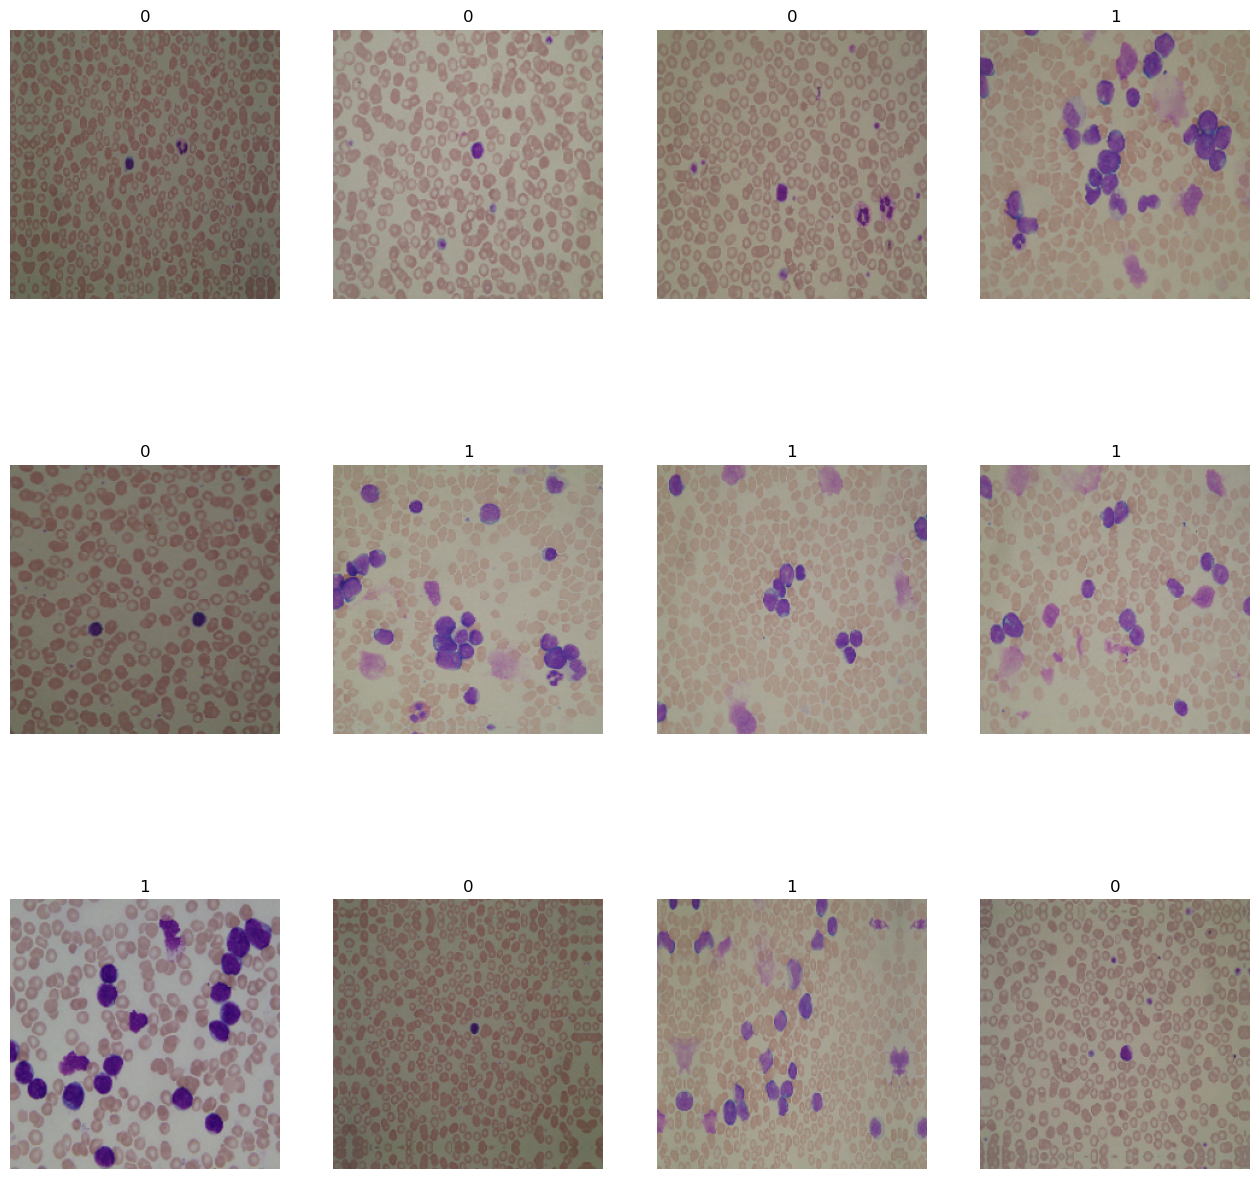

In [37]:
plt.figure(figsize=(16,16))
for i in range(12):
    image,label = train_generator.next()
    plt.subplot(3,4,i+1)
    plt.imshow(image[i])
    plt.title(class_labels[tf.argmax(label[i])])
    plt.axis("off")

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.models import Model
resnet = ResNet50(include_top=False, input_shape=(224,224,3))

for layers in resnet.layers[:-15]:
    layers.trainable=False

x = resnet.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create the complete model
model = Model(inputs=resnet.input, outputs=x)

In [ ]:
optimizer = Adam(epsilon=0.01, learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
checkpoint_path = "C:/Users/tanis/OneDrive/Desktop/mini/Leuke-20epoch_cell.h5"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [ ]:
history = model.fit(train_generator,
          epochs = 1,
          #Wrong
          #steps_per_epoch = 25,
          steps_per_epoch=step_size_train,
#           batch_size =32,
          validation_data = val_generator,
                    #Wrong
#           validation_steps = 1,
          validation_steps=1,
          callbacks=[cp_callback],
          verbose=1)